In [1]:
import torch
from torch.optim import Optimizer
import matplotlib.pyplot as plt
import numpy as np
import time
from utils import MirrorDescent, barycentric_to_cartesian, entropic_mirror_map, test_loop
import torch, time, numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torch.optim import Optimizer
from matplotlib.colors import LogNorm  

In [2]:
def rosenbrock(x: torch.Tensor) -> torch.Tensor:
    return 100.0 * (x[1] - x[0]**2)**2 + (1.0 - x[0])**2

def grad_rosenbrock(x: torch.Tensor) -> torch.Tensor:
    dx = -400 * x[0] * (x[1] - x[0]**2) - 2 * (1 - x[0])
    dy =  200 * (x[1] - x[0]**2)
    return torch.tensor([dx, dy], dtype=torch.float32)

In [3]:
def euclidean_mirror_map(x, grad, lr):
    return x - lr * grad      

In [4]:
def run_md(
    mirror_map,
    x0: np.ndarray | list | torch.Tensor = [-1.5, 1.5],
    lr: float = 1e-3,
    max_iter: int = 40_000,
    tol: float = 1e-5,
):
    x = torch.nn.Parameter(torch.tensor(x0, dtype=torch.float32))
    opt = MirrorDescent([x], lr=lr, mirror_map=mirror_map)
    traj, losses = [x.detach().clone()], []
    t0 = time.time()

    for it in range(max_iter):
        opt.zero_grad(set_to_none=True)
        loss = rosenbrock(x)
        loss.backward()
        opt.step()

        traj.append(x.detach().clone())
        losses.append(loss.item())

        if x.grad.norm() < tol:
            break
    runtime = time.time() - t0
    return torch.stack(traj).cpu().numpy(), np.array(losses), runtime

Running mirror descent from example starting point x_0 = [-1.2, 1.2]

In [5]:
trajectory, losses, elapsed = run_md(
    mirror_map=euclidean_mirror_map,
    x0=[-1.2,1.2],
    lr=2e-4,        
    max_iter=60_000
)

print(f"final point: {trajectory[-1]},  f(x)={losses[-1]:.3e},  steps={len(losses)},  time={elapsed:.2f}s")


final point: [0.9964234 0.9928455],  f(x)=1.281e-05,  steps=60000,  time=21.48s


In [6]:
xx, yy = np.meshgrid(np.linspace(-2, 2, 400), np.linspace(-1, 3, 400))
zz = 100*(yy - xx**2)**2 + (1-xx)**2

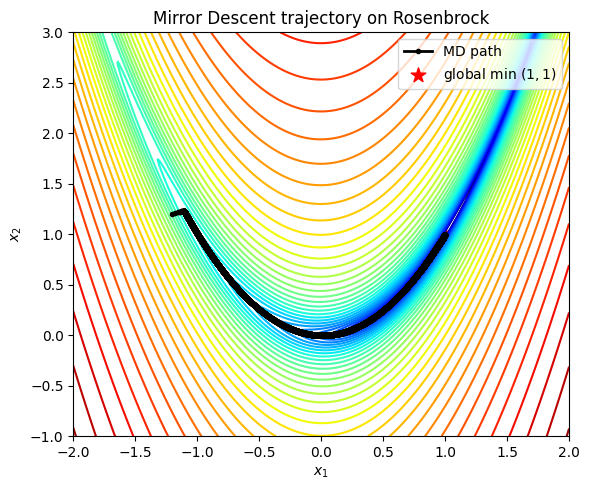

In [61]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

plt.figure(figsize=(6,5))
levels = np.logspace(-1, 3.5, 40)

plt.contour(xx, yy, zz, levels=levels, norm=LogNorm(), cmap="jet")
plt.plot(trajectory[:,0], trajectory[:,1], "k.-", lw=2, label="MD path")
plt.scatter([1], [1], c="red", marker="*", s=120, label="global min $(1,1)$")
plt.xlabel("$x_1$"); plt.ylabel("$x_2$")
# plt.xlim(-2, 2); plt.ylim(-2, 2)
plt.title("Mirror Descent trajectory on Rosenbrock")
plt.legend(); plt.tight_layout()

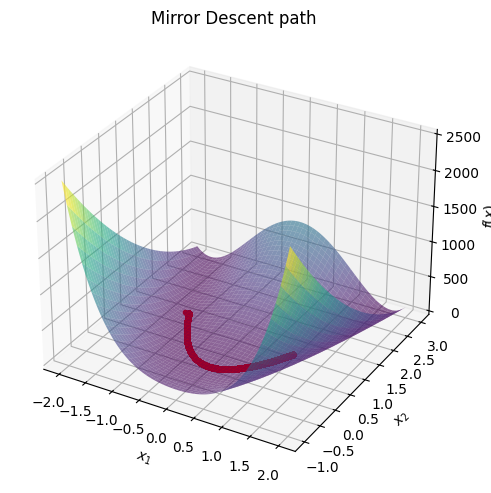

In [ ]:
fig = plt.figure(figsize=(7,5))
ax  = fig.add_subplot(111, projection="3d")

ax.plot_surface(xx, yy, zz, rstride=8, cstride=8,
                alpha=0.6, cmap="viridis", lw=0.2)

ax.plot(trajectory[1:,0], trajectory[1:,1], losses, "r.-", lw=2)

ax.set_xlabel("$x_1$"); ax.set_ylabel("$x_2$"); ax.set_zlabel("$f(x)$")
ax.set_title("Mirror Descent path")
plt.tight_layout()

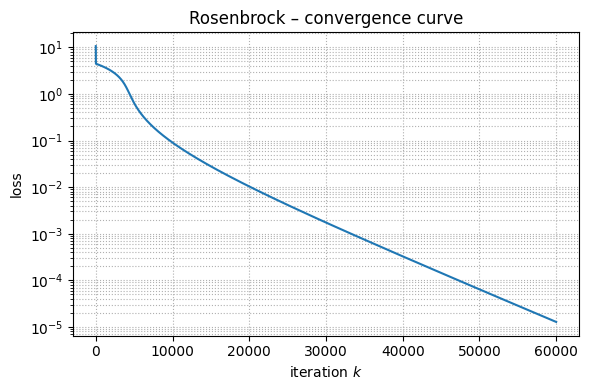

In [73]:
plt.figure(figsize=(6,4))
plt.semilogy(losses, label="$f(x_k)$")
plt.xlabel("iteration $k$"); plt.ylabel("loss")
plt.title("Rosenbrock – convergence curve")
plt.grid(True, which="both", ls=":")
# plt.legend()
plt.tight_layout()

In [ ]:
from matplotlib.colors import LogNorm

init_points = np.array([
    [-1.8,  1.8],
    [-1.5, -0.5],
    [-0.5,  1.5],
    [ 1.5, -0.7],
    [-1.2,  1.2]           
])

trajectories = []
for x0 in init_points:
    print(f"Running MD from x0={x0}")
    traj, _, _ = run_md(
        mirror_map=euclidean_mirror_map,
        x0=x0,
        lr=2e-4,
        max_iter=60_000
    )
    trajectories.append(traj)


Running MD from x0=[-1.8  1.8]
Running MD from x0=[-1.5 -0.5]
Running MD from x0=[-0.5  1.5]
Running MD from x0=[ 1.5 -0.7]
Running MD from x0=[-1.2  1.2]


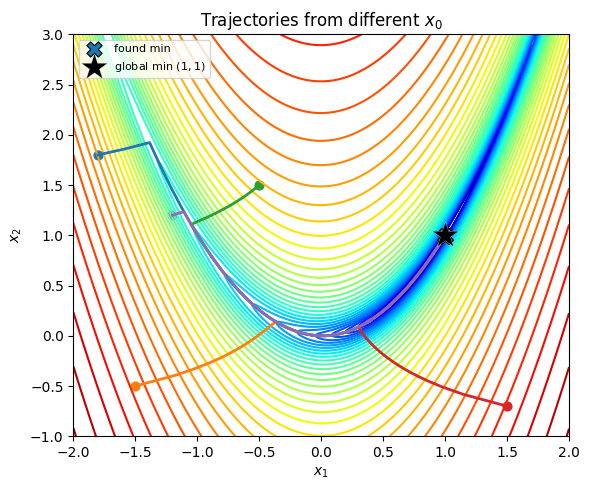

In [67]:
plt.figure(figsize=(6,5))
levels = np.logspace(-1, 3.5, 40)
plt.contour(xx, yy, zz, levels=levels, cmap="jet", norm=LogNorm())

colors = plt.cm.tab10(range(len(init_points)))
for idx, (c, trj, x0) in enumerate(zip(colors, trajectories, init_points)):
    plt.plot(trj[:,0], trj[:,1], color=c, lw=2)  # full path
    plt.scatter(*x0, color=c, marker="o", s=40)  # start point
    plt.scatter(
        trj[-1,0], trj[-1,1],
        color=c,
        marker="X",             
        s=120,                 
        edgecolors="k",
        linewidths=0.8,
        zorder=4,
        label="found min" if idx==0 else None 
    )

# global minimum
plt.scatter(
    [1], [1],
    c="k", marker="*", s=400,
    edgecolors="w", linewidths=0.2,
    zorder=5, label="global min $(1,1)$"
)

plt.xlabel("$x_1$"); plt.ylabel("$x_2$")
plt.title("Trajectories from different $x_0$")
plt.legend(loc="upper left", fontsize=8); plt.tight_layout()

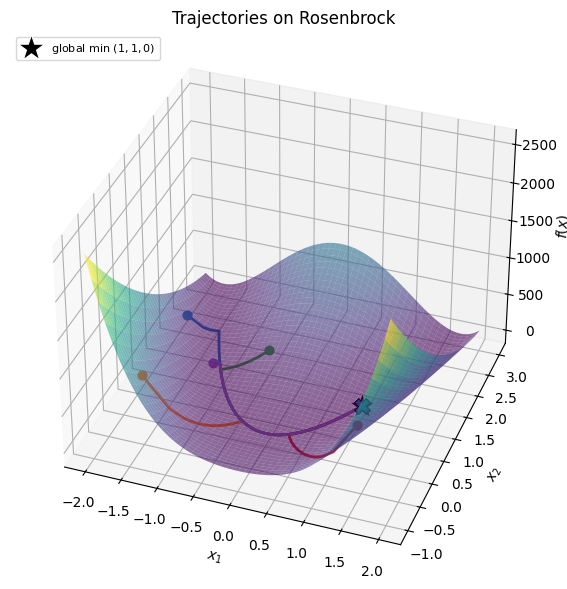

In [ ]:
fig = plt.figure(figsize=(8,6))
ax  = fig.add_subplot(111, projection="3d")

ax.plot_surface(xx, yy, zz,
                rstride=8, cstride=8,
                alpha=0.6, cmap="viridis", lw=0.2)

colors = plt.cm.tab10(np.arange(len(trajectories)))
for c, trj in zip(colors, trajectories):
    f_vals = 100*(trj[:,1] - trj[:,0]**2)**2 + (1 - trj[:,0])**2   # f(x) for every iterate

    ax.plot(trj[:,0], trj[:,1], f_vals, color=c, lw=2)

    ax.scatter(trj[0,0], trj[0,1], f_vals[0],
               color=c, marker="o", s=40, zorder=4)

    ax.scatter(trj[-1,0], trj[-1,1], f_vals[-1],
               color=c, marker="X", s=120,
               edgecolors="k", linewidths=0.6, zorder=5)

ax.scatter(1, 1, 0,
           c="k", marker="*", s=400,
           edgecolors="w", linewidths=0.8, zorder=6,
           label="global min $(1,1,0)$")

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$f(x)$")
ax.set_title("Trajectories on Rosenbrock")
ax.view_init(elev=35, azim=-70)
plt.legend(loc="upper left", fontsize=8); plt.tight_layout()   
plt.tight_layout()
plt.show()

In [ ]:
def benchmark(
    seeds: int = 50,
    lr: float = 2e-4,
    max_iter: int = 60_000,
    thresholds=(1, 1e-1, 1e-2, 1e-3, 1e-4)
):
    stats = {t: [] for t in thresholds}
    times, finals = [], []

    for s in range(seeds):
        print(f"Running seed {s+1}/{seeds}... ", flush=True)
        torch.manual_seed(s)
        # random start in the box [-2, 2] x [-2, 2]
        x0 = np.array([-2.0, -2.0]) + np.random.rand(2) * np.array([4.0, 4.0])
        traj, loss, rt = run_md(euclidean_mirror_map, x0, lr, max_iter)
        times.append(rt); finals.append(loss[-1])

        for t in thresholds:
            print(f"threshold {t:.0e}...", end="", flush=True)
            hit = np.argmax(loss < t)       
            stats[t].append(hit if loss.min() < t else max_iter)
        print("\n")

    return stats, np.array(times), np.array(finals)

In [59]:
stats, times, finals = benchmark(seeds=50)  

Running seed 1/50... 
threshold 1e+00...threshold 1e-01...threshold 1e-02...threshold 1e-03...threshold 1e-04...

Running seed 2/50... 
threshold 1e+00...threshold 1e-01...threshold 1e-02...threshold 1e-03...threshold 1e-04...

Running seed 3/50... 
threshold 1e+00...threshold 1e-01...threshold 1e-02...threshold 1e-03...threshold 1e-04...

Running seed 4/50... 
threshold 1e+00...threshold 1e-01...threshold 1e-02...threshold 1e-03...threshold 1e-04...

Running seed 5/50... 
threshold 1e+00...threshold 1e-01...threshold 1e-02...threshold 1e-03...threshold 1e-04...

Running seed 6/50... 
threshold 1e+00...threshold 1e-01...threshold 1e-02...threshold 1e-03...threshold 1e-04...

Running seed 7/50... 
threshold 1e+00...threshold 1e-01...threshold 1e-02...threshold 1e-03...threshold 1e-04...

Running seed 8/50... 
threshold 1e+00...threshold 1e-01...threshold 1e-02...threshold 1e-03...threshold 1e-04...

Running seed 9/50... 
threshold 1e+00...threshold 1e-01...threshold 1e-02...threshold 1e

,mean,std,min,max
1.0000,1450.96,2341.056050,0.0,8810.0
0.1000,6258.48,5313.487118,12.0,20718.0
0.0100,17020.24,8987.296780,21.0,39906.0
0.0010,30184.38,10619.899494,28.0,55735.0
0.0001,43625.26,9754.676159,9941.0,60000.0


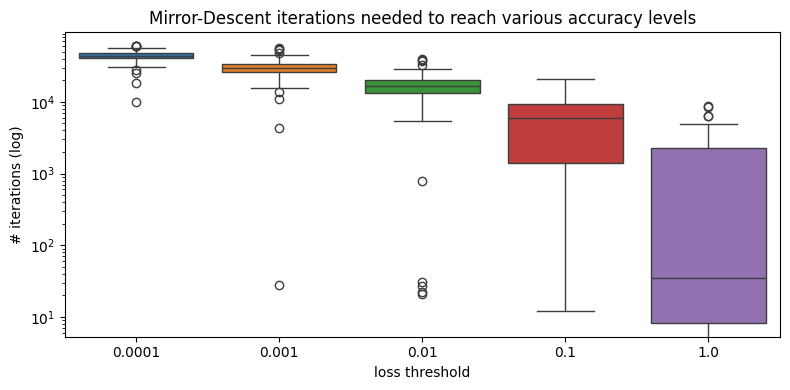

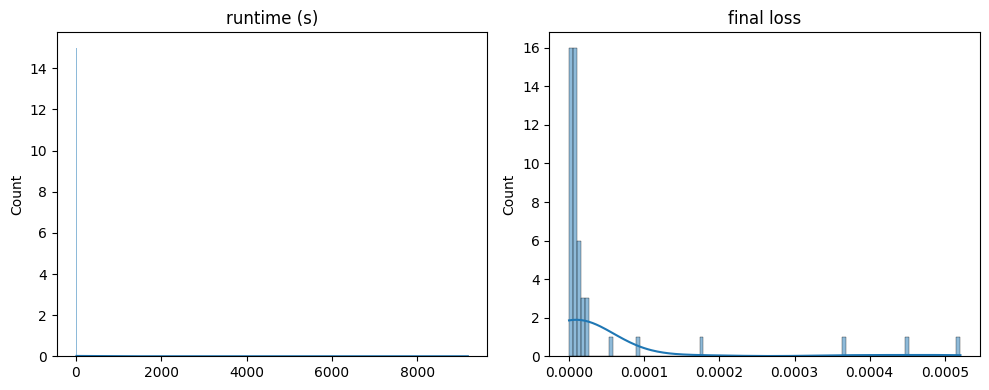

In [ ]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(stats)
display(df.describe().T[["mean","std","min","max"]])

plt.figure(figsize=(8,4))
sns.boxplot(data=df)
plt.yscale("log"); plt.xlabel("loss threshold"); plt.ylabel("# iterations (log)")
plt.title("Mirror-Descent iterations needed to reach various accuracy levels")
plt.tight_layout()

fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.histplot(times,  kde=True, ax=ax[0]); ax[0].set_title("runtime (s)")
sns.histplot(finals, kde=True, ax=ax[1]); ax[1].set_title("final loss")
plt.tight_layout()

In [ ]:
stats_30, times_30, finals_30 = benchmark(seeds=30)  

Running seed 1/30... 
threshold 1e+00...threshold 1e-01...threshold 1e-02...threshold 1e-03...threshold 1e-04...
Running seed 2/30... 
threshold 1e+00...threshold 1e-01...threshold 1e-02...threshold 1e-03...threshold 1e-04...
Running seed 3/30... 
threshold 1e+00...threshold 1e-01...threshold 1e-02...threshold 1e-03...threshold 1e-04...
Running seed 4/30... 
threshold 1e+00...threshold 1e-01...threshold 1e-02...threshold 1e-03...threshold 1e-04...
Running seed 5/30... 
threshold 1e+00...threshold 1e-01...threshold 1e-02...threshold 1e-03...threshold 1e-04...
Running seed 6/30... 
threshold 1e+00...threshold 1e-01...threshold 1e-02...threshold 1e-03...threshold 1e-04...
Running seed 7/30... 
threshold 1e+00...threshold 1e-01...threshold 1e-02...threshold 1e-03...threshold 1e-04...
Running seed 8/30... 
threshold 1e+00...threshold 1e-01...threshold 1e-02...threshold 1e-03...threshold 1e-04...
Running seed 9/30... 
threshold 1e+00...threshold 1e-01...threshold 1e-02...threshold 1e-03...th

,mean,std,min,max
1.0000,2300.833333,3275.403814,1.0,9154.0
0.1000,8004.133333,5570.887602,5.0,20157.0
0.0100,19585.766667,8467.329399,19.0,39345.0
0.0010,32791.900000,10413.733347,29.0,55174.0
0.0001,46122.800000,9071.598481,14435.0,60000.0


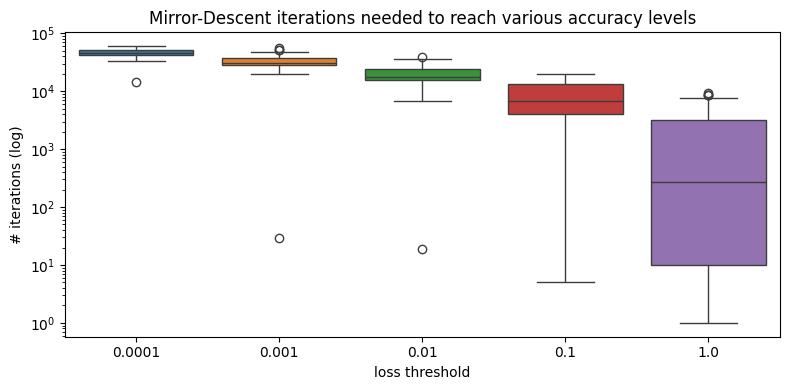

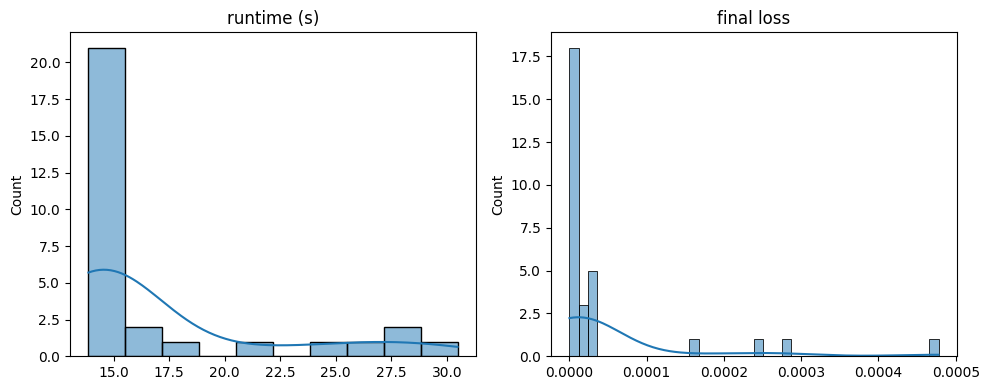

In [53]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(stats_30)
display(df.describe().T[["mean","std","min","max"]])

plt.figure(figsize=(8,4))
sns.boxplot(data=df)
plt.yscale("log"); plt.xlabel("loss threshold"); plt.ylabel("# iterations (log)")
plt.title("Mirror-Descent iterations needed to reach various accuracy levels")
plt.tight_layout()

fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.histplot(times_30,  kde=True, ax=ax[0]); ax[0].set_title("runtime (s)")
sns.histplot(finals_30, kde=True, ax=ax[1]); ax[1].set_title("final loss")
plt.tight_layout()